In [1]:
!pip install python-Levenshtein

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 28.9 MB/s eta 0:00:00

   ---------------------------------------- 3/3 [python-Levenshtein]



In [ ]:
import pandas as pd
working_dir = 'C:/Users/carja/Documents/Capstone/'
df = pd.read_csv(working_dir + 'analyzedTracks.csv')

# remove playlist related columns
df = df.drop(columns=['pos','playlist_num_albums','playlist_num_artists','playlist_num_followers','playlist_collaborative','playlist_pid','album_name','playlist_num_tracks','playlist_name','duration_ms','playlist_pid'])

#remove key since it's redundant w/ tonic & mode
df = df.drop('estimated_key', axis=1)

# remove rows w/out a progression -- most likely audio was correct or absent
df = df.dropna(subset=['progression1'])

#remove duplicate tracks
df = df.drop_duplicates(subset=['artist_name', 'track_name'])

# Store track_name and artist_name separately
meta_cols = df[['track_name', 'artist_name']].copy()
df_cleaned = df.drop(['track_name', 'artist_name'], axis=1)
df_cleaned.head()


In [150]:
#Normalize numerical features
from sklearn.preprocessing import StandardScaler

num_cols = ['tempo', 'spectral_contrast_mean', 'spectral_contrast_var',
            'spectral_centroid_mean', 'spectral_centroid_var',
            'spectral_flatness_mean', 'spectral_flatness_var']
scaler = StandardScaler()
X_num = scaler.fit_transform(df_cleaned[num_cols])

X_num_df = pd.DataFrame(X_num, columns=num_cols, index=df_cleaned.index)
X_num_df.head()

,tempo,spectral_contrast_mean,spectral_contrast_var,spectral_centroid_mean,spectral_centroid_var,spectral_flatness_mean,spectral_flatness_var
0,0.365897,-1.603531,-0.181108,0.832327,0.154847,1.833490,1.945933
1,1.603289,-0.912067,-0.310495,0.930802,1.087980,0.140211,-0.248783
2,0.915849,-1.194545,0.560344,0.818152,-0.233319,0.567694,0.611902
3,0.915849,-1.014192,0.368662,2.032243,0.350148,1.194220,0.197322
4,0.626400,0.187249,-0.670132,0.658432,0.133413,0.225920,0.617056


In [151]:
#One Hot Encode Categoricals
X_cat = pd.get_dummies(df_cleaned[['tonic', 'mode']])

X_cat_df = pd.DataFrame(X_cat, columns=['tonic', 'mode'], index=df_cleaned.index)
X_cat.head()

,tonic_A,tonic_A#,tonic_B,tonic_C,tonic_C#,tonic_D,tonic_D#,tonic_E,tonic_F,tonic_F#,tonic_G,tonic_G#,mode_major,mode_minor
0,False,False,False,False,False,False,False,False,True,False,False,False,True,False
1,True,False,False,False,False,False,False,False,False,False,False,False,True,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True,False,False,False,False,True,False


In [152]:
import numpy as np
import pandas as pd
from Levenshtein import distance
from sklearn.decomposition import TruncatedSVD

def normalize_dist(a, b):
    if not a or not b:
        return 1.0
    max_len = max(len(a), len(b))
    return distance(a, b) / max_len if max_len > 0 else 0

def compute_progression_distance_matrix(df):
    n = len(df)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        p1_i = ' '.join(df.iloc[i]['progression1']) if isinstance(df.iloc[i]['progression1'], list) else ''
        p2_i = ' '.join(df.iloc[i]['progression2']) if isinstance(df.iloc[i]['progression2'], list) else ''

        for j in range(i + 1, n):
            p1_j = ' '.join(df.iloc[j]['progression1']) if isinstance(df.iloc[j]['progression1'], list) else ''
            p2_j = ' '.join(df.iloc[j]['progression2']) if isinstance(df.iloc[j]['progression2'], list) else ''

            d1 = normalize_dist(p1_i, p1_j)
            d2 = normalize_dist(p2_i, p2_j)
            d3 = normalize_dist(p1_i, p2_j)
            d4 = normalize_dist(p2_i, p1_j)

            min_dist = min(d1, d2, d3, d4)
            dist_matrix[i, j] = dist_matrix[j, i] = min_dist

    return dist_matrix

# Embed to N-dimensional space (e.g., 2D or 5D)
D_prog = compute_progression_distance_matrix(df_cleaned)
similarity_matrix = 1 - D_prog
similarity_matrix = np.nan_to_num(similarity_matrix, nan=0)  # treat NaN similarity as 0 (no similarity)

embedding = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
prog_embedded = embedding.fit_transform(D_prog)

In [179]:
"""
Prints the top `top_features_per_factor` contributing features for the first `top_n` SVD components.
"""
def print_top_svd_factors(svd, feature_names, top_n=5):
    for i in range(min(top_n, svd.components_.shape[0])):
        component = svd.components_[i]
        top_indices = np.argsort(np.abs(component))[::-1]
        top_features = [(feature_names[j], component[j]) for j in top_indices]

        print(f"\nSVD Factor {i+1}:")
        for name, weight in top_features:
            print(f"  {name}: {weight:.4f}")

w_num = 0.2     # weight for spectral/numerical features
w_cat = 0.2    # weight for categorical features
w_prog = 0.6   # weight for progression embeddings

X_total = np.hstack([
    X_num * w_num,
    X_cat * w_cat,
    prog_embedded * w_prog
])
#X_total = np.hstack([X_num, X_cat.values, prog_embedded])
svd = TruncatedSVD(n_components=10)
X_reduced = svd.fit_transform(X_total)

# Numeric column names
num_col_names = list(df_cleaned[num_cols].columns)
# Categorical column names
cat_col_names = list(X_cat.columns)
# Progression embedding column names
prog_col_names = [f'prog_embedded_{i}' for i in range(prog_embedded.shape[1])]

#Combine all column names
feature_names = num_col_names + cat_col_names + prog_col_names
print_top_svd_factors(svd, feature_names, top_n=5)


SVD Factor 1:
  spectral_flatness_mean: 0.5493
  spectral_contrast_mean: -0.4617
  spectral_flatness_var: 0.4505
  spectral_centroid_mean: 0.3761
  spectral_centroid_var: 0.3459
  spectral_contrast_var: 0.1079
  mode_major: -0.0503
  mode_minor: 0.0472
  tempo: 0.0448
  prog_embedded_0: -0.0415
  tonic_D: -0.0174
  tonic_A: 0.0143
  prog_embedded_2: 0.0113
  tonic_G#: -0.0086
  tonic_F#: 0.0077
  tonic_E: 0.0060
  tonic_F: -0.0057
  prog_embedded_1: 0.0034
  tonic_C#: 0.0031
  tonic_A#: -0.0017
  tonic_G: -0.0010
  tonic_D#: -0.0005
  tonic_C: 0.0004
  tonic_B: 0.0002

SVD Factor 2:
  prog_embedded_0: 0.6216
  spectral_centroid_mean: 0.3679
  spectral_flatness_var: -0.3346
  spectral_contrast_var: 0.3322
  prog_embedded_1: 0.2714
  prog_embedded_2: 0.2523
  spectral_contrast_mean: -0.2264
  spectral_flatness_mean: -0.1709
  tempo: 0.1462
  mode_major: -0.0741
  spectral_centroid_var: -0.0733
  mode_minor: 0.0665
  tonic_C: -0.0189
  tonic_B: -0.0179
  tonic_G: 0.0167
  tonic_D: 0.0161

In [180]:
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

def compare_tracks(idx1, idx2, svd_features, alpha=0.7):
    """
    Compares two tracks by computing cosine similarity between their SVD-reduced vectors.
    
    Parameters:
        idx1, idx2: Row indices of the two tracks in the original dataframe.
        svd_features: 2D array of SVD-transformed features (output from svd.fit_transform).
    
    Returns:
        similarity: Float cosine similarity score between the two tracks (0 to 1).
    """
    vec1 = svd_features[idx1].reshape(1, -1)
    vec2 = svd_features[idx2].reshape(1, -1)
    
    similarity = cosine_similarity(vec1, vec2)[0][0]
    return similarity

# Append metadata back to the original DataFrame or to your results
df_result = pd.concat([df_cleaned, meta_cols], axis=1)

# Compare all unique pairs and store similarities
similarities = []
for i, j in combinations(range(len(df_result)), 2):
    sim = compare_tracks(i, j, X_reduced)
    similarities.append((i, j, sim))

In [181]:
# Sort by highest similarity
top_matches = sorted(similarities, key=lambda x: x[2], reverse=True)#[:10]

# Show top 10 most similar track pairs
show_count = 0
for i, j, sim in top_matches:
    if(df_result.iloc[i]['artist_name'] != df_result.iloc[j]['artist_name']):
        name1 = df_result.iloc[i]['artist_name'] + ':' + df_result.iloc[i]['track_name']
        name2 = df_result.iloc[j]['artist_name'] + ':' + df_result.iloc[j]['track_name']
        
        print(f"{name1} <-> {name2} | Similarity: {sim:.4f}")
        show_count += 1
    if show_count > 10:
        break

The Lumineers:In The Light <-> Plain White T's:Hey There Delilah | Similarity: 0.9840
Vishal-Shekhar:Zehnaseeb (From "Hasee Toh Phasee") <-> Armaan Malik:Janaan | Similarity: 0.9776
Nakul:Love Elephantla <-> Amar Arshi:Kala Chashma (From "Baar Baar Dekho") | Similarity: 0.9770
Fetty Wap:679 (feat. Remy Boyz) <-> The Weeknd:Can't Feel My Face | Similarity: 0.9721
Manish Kumar Tipu:Gallan Goodiyaan <-> Swedish House Mafia:Don't You Worry Child (Radio Edit) [feat. John Martin] | Similarity: 0.9707
Joseph Vincent:Can't Take My Eyes Off You <-> The Beatles:Yesterday - Remastered | Similarity: 0.9677
Jamie McDell:Moon Shines Red <-> Mithoon:Humnava | Similarity: 0.9661
Jon Bellion:Human - Acoustic <-> Gavin Mikhail:Some Die Young | Similarity: 0.9657
Shakira:La La La (Brasil 2014) <-> Bassjackers:Pillowfight | Similarity: 0.9614
Jason Mraz:Lucky <-> Ellie Goulding:Still Falling For You - Live | Similarity: 0.9611
WVNDER:Footprints (Acoustic) <-> The Beatles:Yesterday - Remastered | Similarit

Best number of clusters: 7


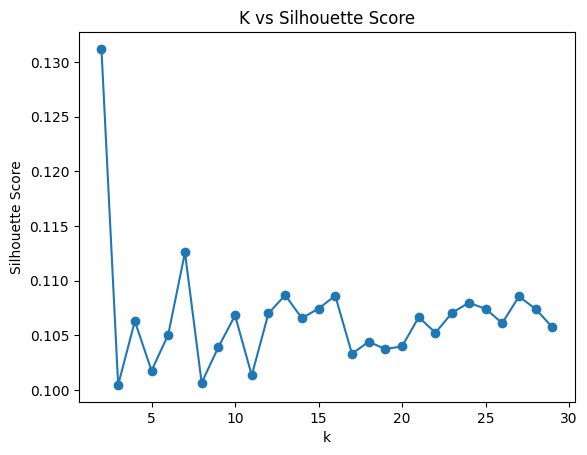

In [217]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def search_best_k(X, k_range=range(2, 21), metric='silhouette'):
    best_k = None
    best_score = -np.inf
    scores = []

    for k in k_range:
        # Cluster the data using KMeans
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        # Score clustering quality
        if metric == 'silhouette':
            score = silhouette_score(X, labels)
        elif metric == 'calinski':
            from sklearn.metrics import calinski_harabasz_score
            score = calinski_harabasz_score(X, labels)
        elif metric == 'davies':
            from sklearn.metrics import davies_bouldin_score
            score = -davies_bouldin_score(X, labels)  # negate since lower is better
        else:
            raise ValueError("Unknown metric")

        scores.append((k, score))

        if k > 2 and score > best_score:
            best_k = k
            best_score = score

    return best_k, scores

# find the K that maximizes grouping among the tracks
best_k, score_list = search_best_k(X_reduced, k_range=range(2, 30), metric='silhouette')
print("Best number of clusters:", best_k)

# Optional: Plot score trend
import matplotlib.pyplot as plt

ks, values = zip(*score_list)
plt.plot(ks, values, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('K vs Silhouette Score')
plt.show()


In [218]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=best_k)
knn.fit(X_reduced)
distances, indices = knn.kneighbors(X_reduced)


In [257]:
import random

def recommend_tracks(track_index, distances, indices, X, track_info, n_recs):
    recs = []
    for i in range(1, min(n_recs + 1, len(indices[track_index]))):  # Skip index 0 (the track itself)
        idx = indices[track_index][i]
        recs.append({
            'track_name': track_info.iloc[idx][ 'track_name'],
            'artist_name': track_info.iloc[idx][ 'artist_name'],
            'distance': distances[track_index][i]
        })
    return recs

# grab a random song and find its k nearest neighbors based on optimal grouping > 2
track_index = random.randint(0, len(track_info))
recommendations = recommend_tracks(track_index, distances, indices, X_reduced, meta_cols, best_k)

for rec in recommendations:
    print(f"Recommendation for:\n   '{track_info.loc[track_index, 'track_name']}' by '{track_info.loc[track_index, 'artist_name']}' is\n   {rec['track_name']} by {rec['artist_name']} (distance: {rec['distance']:.3f})")


Recommendation for:
   'Dessert - Remix' by 'Dawin' is
   No Diggity by Blackstreet (distance: 0.278)
Recommendation for:
   'Dessert - Remix' by 'Dawin' is
   'Till I Collapse by Eminem (distance: 0.282)
Recommendation for:
   'Dessert - Remix' by 'Dawin' is
   Bolide - Radio Edit by Soldat Jahman (distance: 0.312)
Recommendation for:
   'Dessert - Remix' by 'Dawin' is
   Tooh by Vishal-Shekhar (distance: 0.330)
Recommendation for:
   'Dessert - Remix' by 'Dawin' is
   Look What You Made Me Do by Taylor Swift (distance: 0.360)
Recommendation for:
   'Dessert - Remix' by 'Dawin' is
   Main Aisa Kyon Hoon by Shankar-Ehsaan-Loy (distance: 0.384)
